### Library

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import re 
%matplotlib inline 

import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

import nltk
from nltk import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [2]:
df = pd.read_csv('Reviews.csv')

In [3]:
print(df.shape)
df.head(3)

(568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
# for all data is too heavy, make it slim by chose
df2 = df.sample(frac= 0.20,replace = True).reset_index(drop = True)

print(df2.shape)
df2.head()

(113691, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,288499,B000ENUC3S,A1XKHAW6JX686J,Rockville Rock Lover,3,14,1,1146096000,Oh it was AWFUL!,"Having read the other reviews, I wonder if min..."
1,137995,B0002SQ1MG,A1FJ2ZN9U24FMI,"Alfredo Kuba ""HERBIVORE""",0,0,5,1297987200,ABSOLUTELY THE BEST DOG AND CAT FOOD BAR NONE!,Evolution Diet food is by far the healthiest d...
2,129594,B000BICL9O,A2K6EZTL2UVHLU,"Dr. Sean Hokari ""432 o'kelly""",2,2,5,1337731200,Sweet Pork!,"I am currently visiting Minneapolis, MN, from ..."
3,79360,B003TNANSO,ACSGOJCV2169G,Darlene Klischer,0,0,5,1334880000,Super fresh and good,These KIND bars are the best bars I have ever ...
4,559189,B001IZM91Y,A2C8O554YMY2ZL,"Bixby ""Bixby""",1,2,1,1326153600,Very Fatty With Bone Chips,The flavoring in this was just not very good b...


In [5]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113691 entries, 0 to 113690
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      113691 non-null  int64 
 1   ProductId               113691 non-null  object
 2   UserId                  113691 non-null  object
 3   ProfileName             113686 non-null  object
 4   HelpfulnessNumerator    113691 non-null  int64 
 5   HelpfulnessDenominator  113691 non-null  int64 
 6   Score                   113691 non-null  int64 
 7   Time                    113691 non-null  int64 
 8   Summary                 113683 non-null  object
 9   Text                    113691 non-null  object
dtypes: int64(5), object(5)
memory usage: 8.7+ MB


In [6]:
print(df2.isna().sum())
df2.dropna(inplace= True)
df2.isna().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               5
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   8
Text                      0
dtype: int64


Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

What is the distribution of ratings across dataset

In [7]:
print(df2['Score'].value_counts())
rating_pct = df2['Score'].value_counts()/len(df) * 100
rating_pct

5    72720
4    16115
1    10387
3     8573
2     5883
Name: Score, dtype: int64


5    12.792592
4     2.834882
1     1.827237
3     1.508126
2     1.034912
Name: Score, dtype: float64

### ditsributoin review(score)

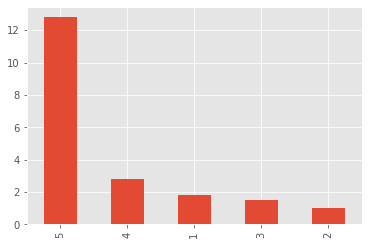

In [8]:
rating_pct.plot.bar()
plt.show()

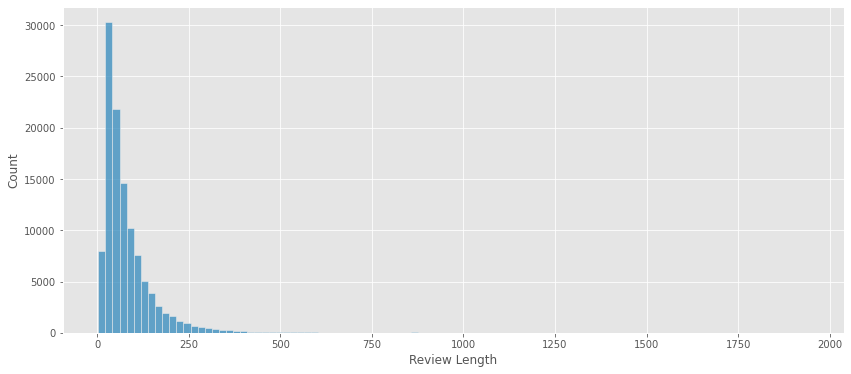

In [9]:
#words per review
plt.figure(figsize = (14,6))
WordsPerReview = df2['Text'].apply(lambda x: len(x.split(' ')))

sns.histplot(WordsPerReview,bins = 100)

plt.xlabel('Review Length')
plt.show()

#### Data Preprocessing and Transformation

In [10]:
df2 = pd.DataFrame(df2,columns = ['Score','Text'])
df2.rename(columns = {'Score':'Rating','Text':'Review'},inplace = True)

In [11]:
df2.head()

,Rating,Review
0,1,"Having read the other reviews, I wonder if min..."
1,5,Evolution Diet food is by far the healthiest d...
2,5,"I am currently visiting Minneapolis, MN, from ..."
3,5,These KIND bars are the best bars I have ever ...
4,1,The flavoring in this was just not very good b...


In [12]:
def apply_sentiment(Rating):
    if(Rating <=2 ):
        return 0
    else:
        return 1

In [13]:
df2['Sentiment'] = df2['Rating'].apply(apply_sentiment)
df2.drop(['Rating'],axis = 1, inplace = True)

In [14]:
sentiment = df2['Sentiment'].value_counts()
sentiment

1    97408
0    16270
Name: Sentiment, dtype: int64

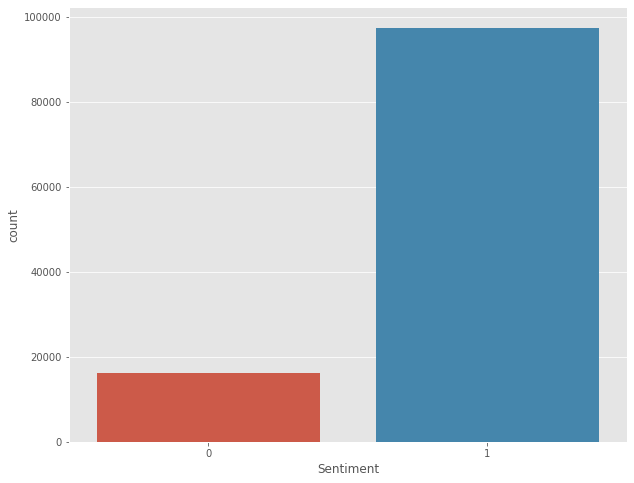

In [15]:
plt.figure(figsize = ( 10,8))
sns.countplot(data = df2, x = 'Sentiment')
plt.show()

In [16]:
def clean_text(Review):
   
    Review = str(Review).lower() # convert to lowercase
    Review = re.sub('\[.*?\]', '', Review) 
    Review = re.sub('https?://\S+|www\.\S+', '', Review) # Remove URls
    Review = re.sub('<.*?>+', '', Review)
    Review = re.sub(r'[^a-z0-9\s]', '', Review) # Remove punctuation
    Review = re.sub('\n', '', Review)
    Review = re.sub('\w*\d\w*', '', Review)
    return Review

In [17]:
df2['Review']

0         Having read the other reviews, I wonder if min...
1         Evolution Diet food is by far the healthiest d...
2         I am currently visiting Minneapolis, MN, from ...
3         These KIND bars are the best bars I have ever ...
4         The flavoring in this was just not very good b...
                                ...                        
113686    I love the taste of the granola. It makes for ...
113687    Like a good bottle of scotch - a very rich and...
113688    I had recently bought an Hawaiian Ice Machine ...
113689    These are awesome! Both the Lime and Mango are...
113690    I ate all 6 cans within the first 48 hours.  A...
Name: Review, Length: 113678, dtype: object

In [18]:
df2['Review'] = df2['Review'].apply(clean_text)

In [19]:
df2.head()

,Review,Sentiment
0,having read the other reviews i wonder if mine...,0
1,evolution diet food is by far the healthiest d...,1
2,i am currently visiting minneapolis mn from ja...,1
3,these kind bars are the best bars i have ever ...,1
4,the flavoring in this was just not very good b...,0


In [20]:
import spacy
nlp = spacy.load("en_core_web_sm")
stopwords = nlp.Defaults.stop_words
df2['Review']= df2['Review'].apply(lambda x:' '.join([i for i in x.split() if i not in stopwords]))

In [21]:
df2.head(3)

,Review,Sentiment
0,having read reviews wonder gone bad fermented ...,0
1,evolution diet food far healthiest dog cat foo...,1
2,currently visiting minneapolis mn japan enjoyi...,1


In [22]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
clf = Pipeline([
    ('vect', CountVectorizer(stop_words= "english")),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB()),
    ])

In [23]:
X = df2['Review']
y = df2['Sentiment']

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = 42,
                                                   test_size = 0.20)
X_train.shape,X_test.shape,y_train.shape

((90942,), (22736,), (90942,))

In [25]:
fit_model = clf.fit(X_train,y_train)

In [27]:
y_pred = clf.predict(X_test)

In [28]:
accuracy_score(y_test, y_pred)

0.858286418015482

In [29]:
print('Training accuracy:', fit_model.score(X_train,y_train))
print('Test accuracy:', fit_model.score(X_test,y_test))

Training accuracy: 0.8595918277583515
Test accuracy: 0.858286418015482
